# Quantum Algorithms for Solving Optimization Problems

## QAOA for solving Max-Cut Problem

In [89]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize

In [6]:
backend = Aer.get_backend('qasm_simulator')

##  5-vertices graph

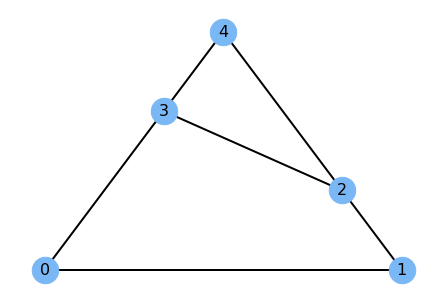

In [79]:
G = nx.Graph()
G.add_edges_from([[0, 1], [1, 2], [0, 3], [2, 3], [3, 4], [2, 4]])
nx.draw(G, with_labels = True, node_color='#7ab8f5', width=2, font_size=16, node_size=700, pos=nx.planar_layout(G))

In [80]:
def C_operator_gates(G, alpha):
    n = G.number_of_nodes()
    qc = QuantumCircuit(n,n)
    
    for i, j in G.edges():
            qc.cx(i, j)
            qc.rz(alpha * 2, j)
            qc.cx(i, j)
            
    return qc

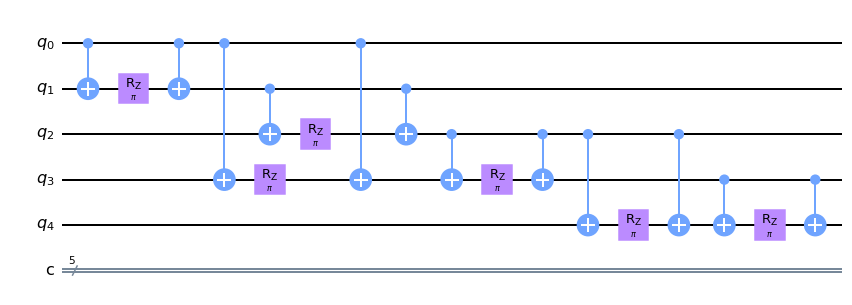

In [81]:
qc = C_operator_gates(G, np.pi / 2)
qc.draw()

In [82]:
def B_operator_gates(G, beta):
    n = G.number_of_nodes()
    qc = QuantumCircuit(n,n)
    
    for node in G.nodes():
        qc.rx(2*beta, node)
        
    return qc


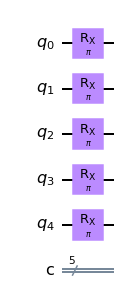

In [83]:
qc = B_operator_gates(G, np.pi/2)
qc.draw()

In [84]:
def create_full_circuit(G, alpha, beta):
    n = G.number_of_nodes()
    qc = QuantumCircuit(n,n)

    qc.h(range(n))
    
    qc += C_operator_gates(G, alpha)
    qc += B_operator_gates(G, beta)
    
    qc.barrier(range(n))
    qc.measure(range(n), range(n))
    
    return qc

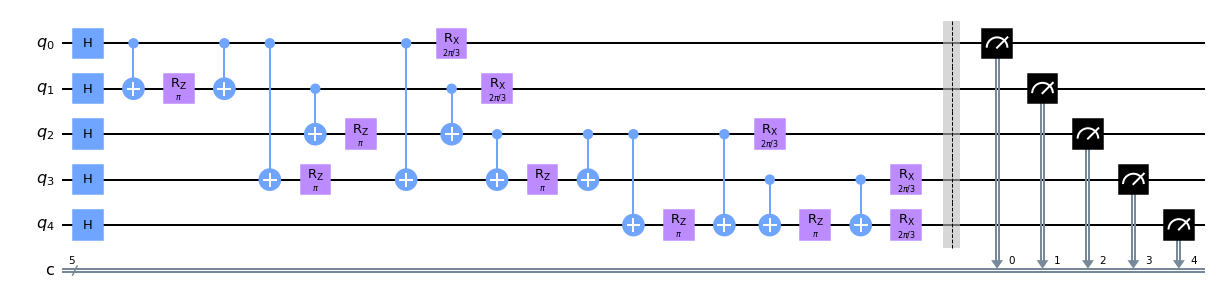

In [85]:
qc_5 = create_full_circuit(G, np.pi/2, np.pi/3)
qc_5.draw()

In [86]:
# helper function to change the orfer of bits returned from Qiskit
def change_order_of_bits(frequencies):
    return {state[::-1]:frequencies for state, frequencies in frequencies.items()}

Distribution of states before optimization


In [87]:
job = execute(qc_5, backend, shots = 3072)
frequencies = change_order_of_bits(job.result().get_counts())
#plot_histogram(frequencies, figsize=(18, 5))

In [88]:
def get_cut_size_from_state_string(G, state):
    cut = 0
    
    for i, j in G.edges():
        if state[i] != state[j]:
            cut += 1
    return cut

In [20]:
def get_average_energy(G, frequencies):
    total_energy = 0
    total_frequencies = 0
    
    for state, frequence in frequencies.items():
        total_energy -= get_cut_size_from_state_string(G, state) * frequence
        total_frequencies += frequence
    avg_energy = total_energy / total_frequencies
    
    return avg_energy

In [21]:
def get_most_frequent_state(frequencies):
    state =  max(frequencies, key=lambda x: frequencies[x])
    
    return state

In [22]:
def get_exact_maxcut(G, frequencies):
    states = [(get_cut_size_from_state_string(G, state), state) for state in frequencies.keys()]
    maxcut, maxcut_state = max(states, key = lambda x: x[0])
    
    return maxcut, maxcut_state

In [23]:
def get_cost_function(G):
    def cost_function(theta):
        alpha = theta[1:]
        beta = theta[:1]
        
        qc = create_full_circuit(G, alpha, beta)
        frequencies = execute(qc, backend, shots=3072, seed_simulator=7).result().get_counts()

        return get_average_energy(G, change_order_of_bits(frequencies))
    return cost_function

In [24]:
def minimize_cost_function(G, init_point):
    cost = get_cost_function(G)
    np_init_point = np.array(init_point)
    result = minimize(cost, np_init_point, method='COBYLA', options={'maxiter':3500, 'disp': True})
    return result

In [25]:
def get_frequencies_for_optimal_cirquit(G, minimization_result):
    params = minimization_result['x']
    qc = create_full_circuit(G, params[1:], params[:1])
    frequencies = change_order_of_bits(execute(qc, backend, shots=20000).result().get_counts())
    
    return frequencies

In [26]:
result = minimize_cost_function(G, [0.84729, 2.60322])
result

     fun: -4.089192708333333
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 33
  status: 1
 success: True
       x: array([1.90635692, 2.82098742])

Distribution of states after optimization

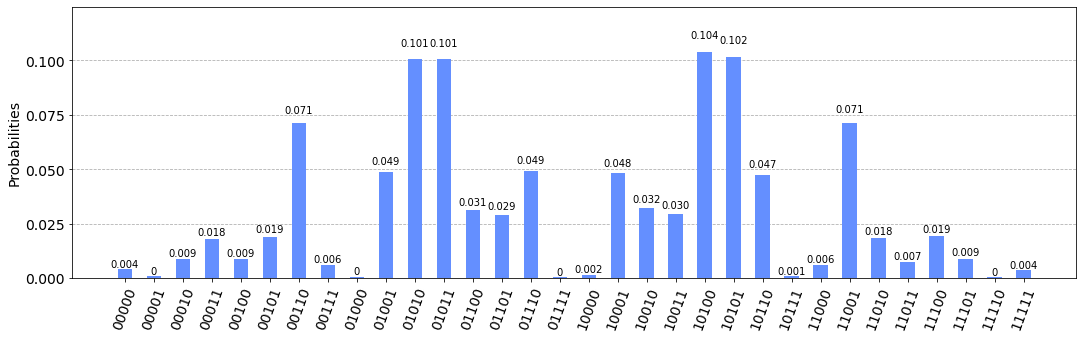

In [31]:
frequencies = get_frequencies_for_optimal_cirquit(G, result)

plot_histogram(frequencies, figsize=(18, 5))

In [38]:
maxcut_state = get_most_frequent_state(frequencies);
maxcut_cut = get_cut_size_from_state_string(G, maxcut_state)
print('QAOA best solution:', maxcut_state, 'with cut size', maxcut_cut)
print('Exact max cut size:', get_exact_maxcut(G, frequencies)[0])
print('Average cut size from all executions: ', -get_average_energy(G, frequencies))

QAOA best solution: 10100 with cut size 5
Exact max cut size: 5
Average cut size from all executions:  4.1101


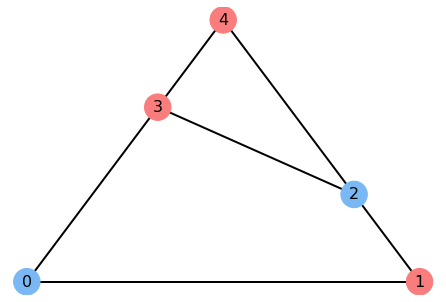

In [39]:
colors = ['#7ab8f5' if maxcut_state[node] == '1' else '#fa7d7d' for node in G]
nx.draw(G, with_labels = True, node_color=colors, width=2, font_size=16, node_size=700, pos=nx.planar_layout(G))

##  10-vertices graph

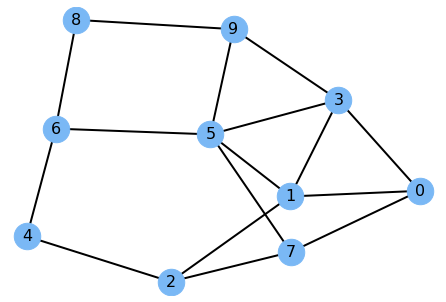

In [40]:
G = nx.Graph()
G.add_edges_from([[0, 1], [6, 8], [9, 8], [9, 5], [1, 2], [9, 3], [0, 3], [2, 4], [1, 3], [3, 5], [1,5], [5, 3], [6,5], [4,6], [7, 2], [7,5], [7, 0]])
nx.draw(G, with_labels = True, node_color='#7ab8f5', width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))

In [41]:
result = minimize_cost_function(G, [2.647339, 3.90922])
frequencies = get_frequencies_for_optimal_cirquit(G, result)
result

     fun: -10.557291666666666
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 36
  status: 1
 success: True
       x: array([2.79231024, 3.44081268])

In [42]:
maxcut_state = get_most_frequent_state(frequencies);
maxcut_cut = get_cut_size_from_state_string(G, maxcut_state)
print('QAOA best solution:', maxcut_state, 'with cut size', maxcut_cut)
print('Exact max cut size:', get_exact_maxcut(G, frequencies)[0])
print('Average cut size from all executions: ', -get_average_energy(G, frequencies))

QAOA best solution: 0101100110 with cut size 13
Exact max cut size: 13
Average cut size from all executions:  10.55285


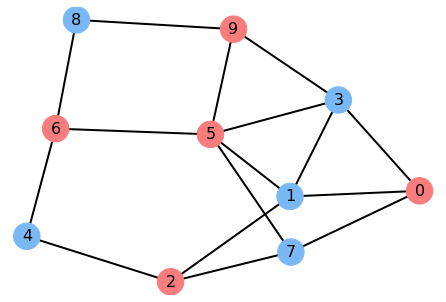

In [43]:
colors = ['#7ab8f5' if maxcut_state[node] == '1' else '#fa7d7d' for node in G]
nx.draw(G, with_labels = True, node_color=colors, width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))

##  20-vertices graph

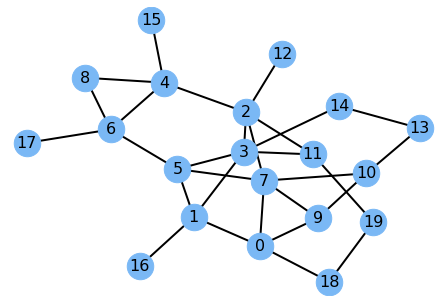

In [64]:
G = nx.Graph()
G.add_edges_from([[0, 1], [12, 2], [13, 10], [14, 13], [15, 4], [16, 1], [17, 6], [18, 0], [19, 18], [6, 8], [8, 4], [9, 7], [9, 0], [10, 9], [11,3], [11, 19], [10, 7], [11, 2], [2, 3], [14, 3], [2, 4], [1, 3], [3, 5], [1,5], [5, 3], [6,5], [4,6], [7, 2], [7,5], [7, 0]])
nx.draw(G, with_labels = True, node_color='#7ab8f5', width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))

In [101]:
result = minimize_cost_function(G, [1.656452, 3.33238])
frequencies = get_frequencies_for_optimal_cirquit(G, result)
result

     fun: -19.152994791666668
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 37
  status: 1
 success: True
       x: array([2.77771133, 3.45212969])

In [102]:
maxcut_state = get_most_frequent_state(frequencies);
maxcut_cut = get_cut_size_from_state_string(G, maxcut_state)
print('QAOA best solution:', maxcut_state, 'with cut size', maxcut_cut)
print('Exact max cut size:', get_exact_maxcut(G, frequencies)[0])
print('Average cut size from all executions: ', -get_average_energy(G, frequencies))

QAOA best solution: 01011011010111000010 with cut size 25
Exact max cut size: 25
Average cut size from all executions:  19.10555


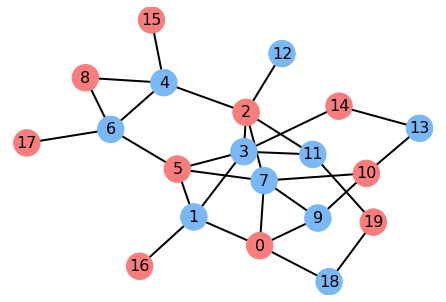

In [103]:
colors = ['#7ab8f5' if maxcut_state[node] == '1' else '#fa7d7d' for node in G]
nx.draw(G, with_labels = True, node_color=colors, width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))

## VQE for Optimizing Stable-Set Problem

In [1]:
import numpy as np

from qiskit import BasicAer
from qiskit.optimization.applications.ising import stable_set
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import L_BFGS_B
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising.common import parse_gset_format, random_graph, sample_most_likely

Here an Operator instance is created for our Hamiltonian. In this case the Paulis are from an Ising Hamiltonian of the maximum stable set problem (expressed in minimization form). We load a small instance of the maximum stable set problem.

In [2]:
w = parse_gset_format('sample.maxcut')
qubitOp, offset = stable_set.get_operator(w)

In [3]:
#Gererating a random graph
if True:
    np.random.seed(8123179)
    w = random_graph(5, edge_prob=0.5)
    qubitOp, offset = stable_set.get_operator(w)
print(w)

[[ 0.  8. -9.  0.  7.]
 [ 8.  0.  9. -8. -1.]
 [-9.  9.  0.  0. -5.]
 [ 0. -8.  0.  0.  0.]
 [ 7. -1. -5.  0.  0.]]


In [4]:
to_be_tested_algos = ['NumPyMinimumEigensolver', 'ClassicalCPLEX', 'VQE']
print(to_be_tested_algos)

['NumPyMinimumEigensolver', 'ClassicalCPLEX', 'VQE']


In [5]:
result = NumPyMinimumEigensolver(qubitOp).run()
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('stable set objective:', result.eigenvalue.real + offset)
print('solution:', stable_set.get_graph_solution(x))
print('solution objective and feasibility:', stable_set.stable_set_value(x, w))

energy: -29.5
stable set objective: -25.0
solution: [0 0 1 1 1]
solution objective and feasibility: (3, False)


In [6]:
try:
    from qiskit.aqua.algorithms import ClassicalCPLEX
    result = ClassicalCPLEX(qubitOp, display=0).run()

    x_dict = result['x_sol']
    print('energy:', result['energy'])
    print('time:', result['eval_time'])
    print('stable set objective:', result['energy'] + offset)
    x = np.array([x_dict[i] for i in sorted(x_dict.keys())])
    print('solution:', stable_set.get_graph_solution(x))
    print('solution objective and feasibility:', stable_set.stable_set_value(x, w))
except Exception as ex:
    print(str(ex))

Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_MIP_Display                             0
CPXPARAM_TimeLimit                               600
CPXPARAM_MIP_Tolerances_MIPGap                   0
CPXPARAM_MIP_Tolerances_Integrality              0
energy: -29.5
time: 0.02447683199999995
stable set objective: -25.0
solution: [0 0 1 1 1]
solution objective and feasibility: (3, False)


Using VQE:

In [7]:
vqe = VQE(qubitOp,
          TwoLocal(qubitOp.num_qubits, ['ry', 'rz'], 'cz', reps=3, entanglement='linear'),
          L_BFGS_B(maxfun=6000))
result = vqe.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('stable set objective:', result.eigenvalue.real + offset)
print('solution:', stable_set.get_graph_solution(x))
print('solution objective and feasibility:', stable_set.stable_set_value(x, w))

energy: -29.49999999994602
time: 18.13162088394165
stable set objective: -24.99999999994602
solution: [0. 0. 1. 1. 1.]
solution objective and feasibility: (3.0, False)


## Grover's Algorithm for solving Lights Out Problem

## Compare the classical algorithm with the quantum version
## 1. Classical Version:
Given a square board of arbitrary size $ n*n $, The solver works by inverting the adjacency matrix of a grid graph of the size of the board. The matrix is defined over the Galois Field GF(2), and the inversion is performed in this field using Gauss-Jordan elimination, with the time complexity  $O( n^3 )$. We can further determine whether the solution exist by examining the rank of the matrix. This algorithm is much better than the enumeration method, since there are $ 2^n $ possible operations on the first row, and the following operations are determined after that, therefore the time complexity will be $O( 2^n )$.

The following is the realization of the classical algorithm, which the time complexity is $O( n^3 )$. Here we take $n=3$ for example.

In [53]:
from operator import add
from itertools import chain, combinations
from functools import reduce

import numpy as np
from scipy import ndimage


class GF2(object):
    """Galois field GF(2)."""
    
    def __init__(self, a=0):
        self.value = int(a) & 1
    
    def __add__(self, rhs):
        return GF2(self.value + GF2(rhs).value)
    
    def __mul__(self, rhs):
        return GF2(self.value * GF2(rhs).value)
    
    def __sub__(self, rhs):
        return GF2(self.value - GF2(rhs).value)
    
    def __truediv__(self, rhs):
        return GF2(self.value / GF2(rhs).value)
    
    def __repr__(self):
        return str(self.value)
    
    def __eq__(self, rhs):
        if isinstance(rhs, GF2):
            return self.value == rhs.value
        return self.value == rhs
    
    def __le__(self, rhs):
        if isinstance(rhs, GF2):
            return self.value <= rhs.value
        return self.value <= rhs
    
    def __lt__(self, rhs):
        if isinstance(rhs, GF2):
            return self.value < rhs.value
        return self.value < rhs
    
    def __int__(self):
        return self.value
    
    def __long__(self):
        return self.value
    

GF2array = np.vectorize(GF2)


def gjel(A):
    """Gauss-Jordan elimination."""
    nulldim = 0
    for i, row1 in enumerate(A):
        pivot = A[i:, i].argmax() + i
        if A[pivot, i] == 0:
            nulldim = len(A) - i
            break
        new_row = A[pivot] / A[pivot, i]
        A[pivot] = A[i]
        row1[:] = new_row
        
        for j, row2 in enumerate(A):
            if j == i:
                continue
            row2[:] -= new_row*A[j, i]
    return A, nulldim


def GF2inv(A):
    """Inversion and eigenvectors of the null-space of a GF2 matrix."""
    n = len(A)
    assert n == A.shape[1], "Matrix must be square"
    
    A = np.hstack([A, np.eye(n)])
    B, nulldim = gjel(GF2array(A))
    
    inverse = np.int_(B[-n:, -n:])
    E = B[:n, :n]
    null_vectors = []
    if nulldim > 0:
        null_vectors = E[:, -nulldim:]
        null_vectors[-nulldim:, :] = GF2array(np.eye(nulldim))
        null_vectors = np.int_(null_vectors.T)
    
    return inverse, null_vectors


def lightsoutbase(n):
    """Base of the LightsOut problem of size (n,n)"""
    a = np.eye(n*n)
    a = np.reshape(a, (n*n, n, n))
    a = np.array(list(map(ndimage.binary_dilation, a)))
    return np.reshape(a, (n*n, n*n))


def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


class LightsOut(object):
    """Lights-Out solver."""
    
    def __init__(self, size=5):
        self.n = size
        self.base = lightsoutbase(self.n)
        self.invbase, self.null_vectors = GF2inv(self.base)
    
    def solve(self, b):
        b = np.asarray(b)
        assert b.shape[0] == b.shape[1] == self.n, "incompatible shape"
        
        if not self.issolvable(b):
            raise ValueError("The given setup is not solvable")
        
        # Find the base solution.
        first = np.dot(self.invbase, b.ravel()) & 1
        
        # Given a solution, we can find more valid solutions
        # adding any combination of the null vectors.
        # Find the solution with the minimum number of 1's.
        solutions = [(first + reduce(add, nvs, 0)) & 1 for nvs in powerset(self.null_vectors)]
        final = min(solutions, key=lambda x: x.sum())
        return np.reshape(final, (self.n, self.n))
    
    def issolvable(self, b):
        """Determine if the given configuration is solvable.
        
        A configuration is solvable if it is orthogonal to
        the null vectors of the base.
        """
        b = np.asarray(b)
        assert b.shape[0] == b.shape[1] == self.n, "incompatible shape"
        b = b.ravel()
        p = [np.dot(x, b) & 1 for x in self.null_vectors]
        return not any(p)
    

def main():
    """Example."""
    lo = LightsOut(3)
    b = np.array([[1, 0, 1],
                  [0, 1, 0],
                  [1, 0, 1]])
    bsol = lo.solve(b)
    print("The solution of\n{}\nis\n{}".format(b, bsol))


if __name__ == '__main__':
    main()

The solution of
[[1 0 1]
 [0 1 0]
 [1 0 1]]
is
[[1 1 1]
 [1 1 1]
 [1 1 1]]


## 2. Quantum Version

This search algorithm reduces the time complexity of searching the solution space to $O(\sqrt N)$.
As the quantum world is probabilistic, a deterministic answer is not always possible most of the times. Thus, this algorithm outputs the correct state 99.95 % of the times.

In [54]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import IBMQ, execute
from qiskit import *
from qiskit.visualization import plot_histogram
import time
import warnings

warnings.filterwarnings('ignore')

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

### Initializing the qubits and classical bits 

Initializing all the required qubits and classical bits.
In this example, the arrangement of the lights is:


[1 0 1        
 0 1 0        
 1 0 1]       

Where 1 means turned on, 0 means turned off.
The above light arrangement can be changed as per the initial lights condition on the board.

In [56]:
tile = QuantumRegister(9,name='tile')
flip = QuantumRegister(9,name='flip')
oracle = QuantumRegister(1,name='oracle')
auxiliary = QuantumRegister(7,name='auxiliary')
result = ClassicalRegister(9,name='result')
qc = QuantumCircuit(tile, flip, oracle, auxiliary, result)

'''Defining the positions: '''

# (0) | (1) | (2)
# - - - - - - - -  
# (3) | (4) | (5)
# - - - - - - - - 
# (6) | (7) | (8)

initial_lights = [1, 0, 1, 0, 1, 0, 1, 0, 1]

In [57]:
Tile = QuantumRegister(9)
Flip = QuantumRegister(9)
circuit = QuantumCircuit(Tile,Flip,name='Flip Tile')    
#For tile 0,0
circuit.cx(Flip[0], Tile[0]) 
circuit.cx(Flip[0], Tile[1])
circuit.cx(Flip[0], Tile[3])
#----------------------------------------
#For tile 0,1
circuit.cx(Flip[1], Tile[0])
circuit.cx(Flip[1], Tile[1])
circuit.cx(Flip[1], Tile[2])
circuit.cx(Flip[1], Tile[4])
#----------------------------------------
#For tile 0,2
circuit.cx(Flip[2], Tile[1])
circuit.cx(Flip[2], Tile[2])
circuit.cx(Flip[2], Tile[5])
#----------------------------------------
#For tile 1,0
circuit.cx(Flip[3], Tile[0])
circuit.cx(Flip[3], Tile[3])
circuit.cx(Flip[3], Tile[4])
circuit.cx(Flip[3], Tile[6])
#----------------------------------------
#For tile 1,1
circuit.cx(Flip[4], Tile[1])
circuit.cx(Flip[4], Tile[3])
circuit.cx(Flip[4], Tile[4])
circuit.cx(Flip[4], Tile[5])
circuit.cx(Flip[4], Tile[7])
#----------------------------------------
#For tile 1,2
circuit.cx(Flip[5], Tile[2])
circuit.cx(Flip[5], Tile[4])
circuit.cx(Flip[5], Tile[5])
circuit.cx(Flip[5], Tile[8])
#----------------------------------------
#For tile 2,0
circuit.cx(Flip[6], Tile[3])
circuit.cx(Flip[6], Tile[6])
circuit.cx(Flip[6], Tile[7])
#----------------------------------------
#For tile 2,1
circuit.cx(Flip[7], Tile[4])
circuit.cx(Flip[7], Tile[6])
circuit.cx(Flip[7], Tile[7])
circuit.cx(Flip[7], Tile[8])
#----------------------------------------
#For tile 2,2
circuit.cx(Flip[8], Tile[5])
circuit.cx(Flip[8], Tile[7])
circuit.cx(Flip[8], Tile[8])
#circuit.draw()
Flip_tile = circuit.to_gate()

In [58]:
Tile = QuantumRegister(9)
Flip = QuantumRegister(9)
OracleQubit = QuantumRegister(1)
Auxiliary = QuantumRegister(7)
Oraclecircuit = QuantumCircuit(tile, flip, oracle, auxiliary,name='Oracle Function')

Oraclecircuit.append(Flip_tile,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
Oraclecircuit.x(tile[0:9])
Oraclecircuit.mct(tile[0:9], oracle[0], auxiliary[0:7], mode='basic')
Oraclecircuit.x(tile[0:9])
Oraclecircuit.append(Flip_tile,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

Oracle_gate = Oraclecircuit.to_gate()

In [59]:
Flip = QuantumRegister(9)
OracleQubit = QuantumRegister(1)
Auxiliary = QuantumRegister(7)
Diffusioncircuit = QuantumCircuit(Flip, OracleQubit, Auxiliary,name='Diffusion Function')

Diffusioncircuit.h(Flip)
Diffusioncircuit.x(Flip)
Diffusioncircuit.h(Flip[8])
Diffusioncircuit.mct(Flip[0:8], Flip[8], Auxiliary[0:7], mode='basic')
Diffusioncircuit.h(Flip[8])
Diffusioncircuit.x(Flip)
Diffusioncircuit.h(Flip)

Diffusion_gate = Diffusioncircuit.to_gate()

In the Diffusion circuit, the amplitude of the marked state is amplified, thus reducing the amplitude of other undesirable states. 

These two circuits combined forms this block. This whole block is repeated a certain number of times (In our case, 17 times). It is the optimum possible number that we want for this 3*3 board configuration. This number depends on the number of qubits used to represent the solution space. In our case, it is 9 qubits. Thus the number of iteration to be performed is calculated as below,

$ \pi/4 *  2^{4.5} $ ∼ 17

The amplitude is increased a little bit whenever we repeat the block. Finally, after 17 iterations, the amplitude of the desired output is increased drastically compared to other states. Thus, if we measure the superposition at this stage, we will get the desired state with a very high probability(99.95%).

In [60]:
counter = 0
for i in initial_lights:
    if i==1:
        qc.x(tile[counter])
        counter+=1
    else:
        counter+=1
qc.h(flip[0:9])
qc.x(oracle[0])
qc.h(oracle[0]) 
qc.barrier()

# The Oracle and Diffusion function is repeated 17 times.
for i in range(17):
    
    #flip_tile(qc,flip,tile)
    qc.append(Oracle_gate,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])

    # diffusion function 
    qc.append(Diffusion_gate,[9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
qc.barrier()

# Uncompute Unit
qc.h(oracle[0])
qc.x(oracle[0])
qc.barrier()

# Measuremnt 
qc.measure(flip,result)

# Reverse the order fo output to match the Input.
qc = qc.reverse_bits()

# Drawing the quantum circuit
# For drawing the final circuit uncomment the below line
#qc.draw() 

In [61]:
start = time.time()
job = execute(qc, backend=backend, shots=512, seed_simulator=1000)#, optimization_level =3)
end = time.time()
print(end-start)

8.319522619247437


{'111111111': 512}


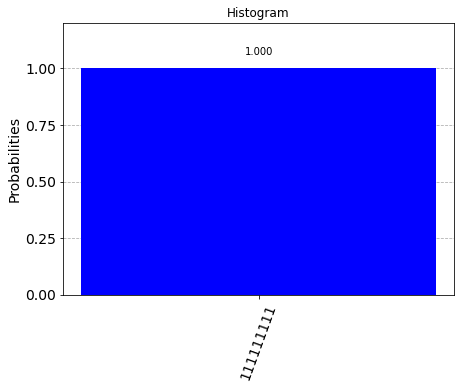

In [62]:
result = job.result()
count = result.get_counts()

print(count)

# Plotting the histogram for puspose of visuzlization 
plot_histogram(job.result().get_counts(), color='blue', title="Histogram")

Now we can see, when the initial stituation of the lights is:

[1 0 1        
 0 1 0        
 1 0 1]       

The solution will be:

[1 1 1        
 1 1 1        
 1 1 1]       

As mentioned above, we can inspect the rank to check whether the solution exist; here another method is provided:

1. If we click the "light in the middle", the 4 lights neighbouring and itself will be switched 

2. If we click the "light at the edge", the 3 lights neighbouring and itself will be switched

3. If we click the "light at the corner", the 2 lights neighbouring and itself will be switched

Therefore, we can initially count the amounts of the turned-on lights of the three different types, and based on the aboved "principle", we can check whether it's possible to solved (this method is a little bit similar to "the invariance principle" in mathematics).